In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

### Using 'Normalized Face' folder from the NUAA Imposter Database

#### Inputting the Dataset

In [2]:
def load_images_from_folder(folder,l):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)

        if os.path.isdir(label_path):

            for filename in os.listdir(label_path):

                img_path = os.path.join(label_path, filename)
                if img_path.endswith(('.jpg', '.jpeg', '.png', '.bmp')):

                    img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
                    if img is not None:

                        images.append(img)
                        labels.append(l)

    return images, labels

In [3]:
# Original Faces(Client) with label 1

path = r"C:\Users\Kartik\OneDrive - IIT Hyderabad\Desktop\Acad_IITH(6th Sem)\IVP\Dataset\NUAA\NormalizedFace\ClientNormalized"
img_real, label_r = load_images_from_folder(path,1)

# Spoof Faces with label -1
path = r"C:\Users\Kartik\OneDrive - IIT Hyderabad\Desktop\Acad_IITH(6th Sem)\IVP\Dataset\NUAA\NormalizedFace\ImposterNormalized"
img_spoof, label_s = load_images_from_folder(path,-1)

image_real = np.array(img_real)
label_real  = np.array(label_r)
image_spoof = np.array(img_spoof)
label_spoof  = np.array(label_s)

#### Defining LBP

In [4]:
from skimage import feature
import numpy as np

class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius
        
    def lbp_calculate(self, image):
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        lbp_image = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")
        
        lbp_r = np.asarray(np.round(lbp_image)).astype(np.uint8)
        return lbp_r

def plot_histogram(image, if_plot=1):
    # Calculate histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Plot histogram
    if if_plot==1:
        plt.plot(hist)
        plt.title('Histogram')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.show()
        
    return hist

#### Region Marking for LBP

In [5]:
def region(image):

    x = 24
    y = 4

    #overlapping region  = 24*4 = 96
    regions = []
    regions.append(image[0:x,0:x])
    regions.append(image[x-y:2*x-y,0:x])
    regions.append(image[2*x-2*y:,0:x])
    regions.append(image[0:x,x-y:2*x-y])
    regions.append(image[x-y:2*x-y,x-y:2*x-y])
    regions.append(image[2*x-2*y:,x-y:2*x-y])
    regions.append(image[0:x,2*x-2*y:])
    regions.append(image[x-y:2*x-y,2*x-2*y:])
    regions.append(image[2*x-2*y:,2*x-2*y:])

    regions = np.array(regions)
    return regions

# Defining the various LBP operators with varying radii and number of points under consideration

LBP_1 = LocalBinaryPatterns(8,1)
LBP_2 = LocalBinaryPatterns(8,2)
LBP_3 = LocalBinaryPatterns(16,2)

# We will be considering only the nonzero histogram features

lbp_img_real_81 = []
lbp_img_spoof_81 = []
i=0

for img in img_real:

    i = i+1
    lbp_img_81 = LBP_1.lbp_calculate(img)
    regions = region(lbp_img_81)
    features = []
    for r in regions:

        feature_histogram = plot_histogram(r,0)
        features.append(feature_histogram[:10])

# Adding the full image image properties
        
    lbp_img_82 = LBP_2.lbp_calculate(img)
    feature_histogram = plot_histogram(lbp_img_82,0)
    features.append(feature_histogram[:10])
    
    lbp_img_162 = LBP_3.lbp_calculate(img)
    feature_histogram = plot_histogram(lbp_img_162,0)
    features.append(feature_histogram[:10])
    
    features = (np.array(features)).reshape(110)

    lbp_img_real_81.append(features)

for img in img_spoof:

    i = i+1
    lbp_img = LBP_1.lbp_calculate(img)
    regions = region(lbp_img)
    features = []

    for r in regions:

        feature_histogram = plot_histogram(r,0)
        features.append(feature_histogram[:10])

    # Adding the full image image properties
        
    lbp_img_82 = LBP_2.lbp_calculate(img)
    feature_histogram = plot_histogram(lbp_img_82,0)
    features.append(feature_histogram[:10])
    
    lbp_img_162 = LBP_3.lbp_calculate(img)
    feature_histogram = plot_histogram(lbp_img_162,0)
    features.append(feature_histogram[:10])
    
    features = (np.array(features)).reshape(110)
    
    lbp_img_spoof_81.append(features)


lbp_img_real_81 = np.array(lbp_img_real_81)
lbp_img_spoof_81 = np.array(lbp_img_spoof_81)

#### Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split

# Concatenating the Dataset

data_set = np.concatenate((lbp_img_spoof_81,lbp_img_real_81),axis=0)
data_set_label = np.concatenate((label_real,label_spoof),axis=0)

# Shuffling the dataset
shuffle_index = np.random.permutation(len(data_set_label))
dataset, d_labels = data_set[shuffle_index,:], data_set_label[shuffle_index]

# Split the data into training and testing sets
d_train, d_test, l_train, l_test = train_test_split(dataset, d_labels, test_size=0.2, random_state=42)

#### SVM based Classifier

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create SVM classifier with RBF kernel
svm_classifier = SVC(kernel='rbf', gamma='scale')

# Train the classifier on the training data
svm_classifier.fit(d_train,l_train)

SVC()

#### Testing the SVM

Accuracy: 0.9552120491478399
Confusion Matrix:
[[1410   88]
 [  25 1000]]
Error Rate: 0.04478795085216014


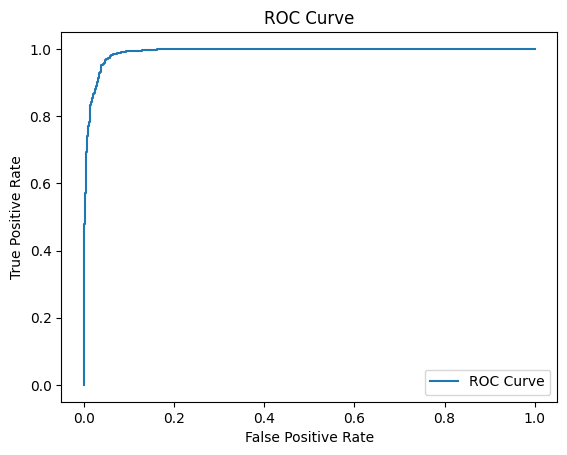

AUC: 0.9905421863297404
Precision: 0.9191176470588235
False Acceptance Rate: 0.08088235294117647
False Fake  Rate: 0.08088235294117647
HTER: 0.04915197786431646


In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, precision_score, roc_auc_score

# Make predictions on the testing data
l_pred = svm_classifier.predict(d_test)

# Calculate accuracy
accuracy = accuracy_score(l_test, l_pred)
print("Accuracy:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(l_test, l_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Error Rate
error_rate = 1 - accuracy
print("Error Rate:", error_rate)

# ROC Curve
y_scores = svm_classifier.decision_function(d_test)
fpr, tpr, thresholds = roc_curve(l_test, y_scores)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Area under ROC Curve (AUC)
auc = roc_auc_score(l_test, y_scores)
print("AUC:", auc)

# Precision
precision = precision_score(l_test, l_pred)
print("Precision:", precision)

# Calculate False Acceptance Rate (FAR)
false_acceptance_rate = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("False Acceptance Rate:", false_acceptance_rate)

# Calculate False Fake Rate (FAR)
false_fake_rate = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[0, 0])
print("False Fake  Rate:", false_acceptance_rate)

# Calculate Half Total Error Rate- HTER
HTER = (false_acceptance_rate + false_fake_rate)/2
print("HTER:", HTER)

#### Quadratic discriminant Analysis(QDA)

Accuracy: 0.6603250099088387
Confusion Matrix:
[[1473   25]
 [ 832  193]]
Error Rate: 0.3396749900911613


c:\Users\Kartik\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


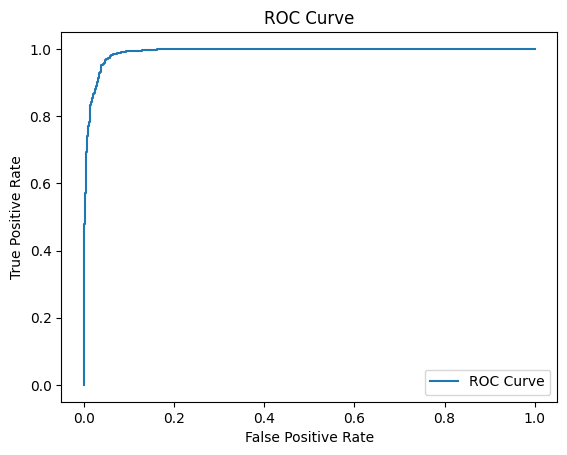

AUC: 0.9905421863297404
Precision: 0.8853211009174312
False Acceptance Rate: 0.11467889908256881
False Fake  Rate: 0.11467889908256881
HTER: 0.2378166729686163


In [9]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, precision_score, roc_auc_score

qda = QuadraticDiscriminantAnalysis()
qda.fit(d_train, l_train)

l_pred = qda.predict(d_test)

# Calculate accuracy
accuracy = accuracy_score(l_test, l_pred)
print("Accuracy:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(l_test, l_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Error Rate
error_rate = 1 - accuracy
print("Error Rate:", error_rate)

# ROC Curve
y_scores = svm_classifier.decision_function(d_test)
fpr, tpr, thresholds = roc_curve(l_test, y_scores)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Area under ROC Curve (AUC)
auc = roc_auc_score(l_test, y_scores)
print("AUC:", auc)

# Precision
precision = precision_score(l_test, l_pred)
print("Precision:", precision)

# Calculate False Acceptance Rate (FAR)
false_acceptance_rate = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("False Acceptance Rate:", false_acceptance_rate)

# Calculate False Fake Rate (FAR)
false_fake_rate = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[0, 0])
print("False Fake  Rate:", false_acceptance_rate)

# Calculate Half Total Error Rate- HTER
HTER = (false_acceptance_rate + false_fake_rate)/2
print("HTER:", HTER)

#### Linear Discriminant Analysis

Accuracy: 0.9595719381688466
Confusion Matrix:
[[1438   60]
 [  42  983]]
Error Rate: 0.04042806183115344


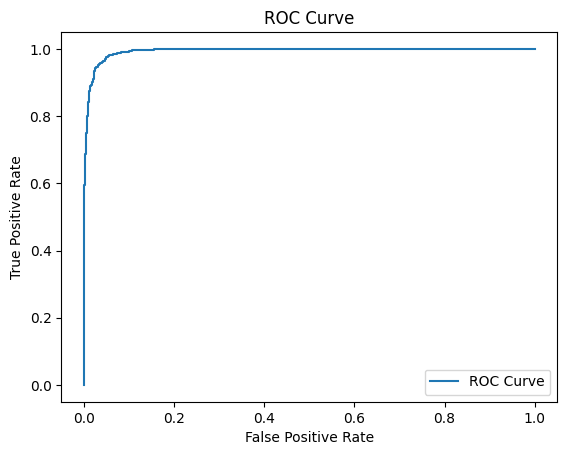

AUC: 0.9934657592236804
Precision: 0.9424736337488016
False Acceptance Rate: 0.05752636625119847
False Fake  Rate: 0.05752636625119847
HTER: 0.04295237231478842


In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, precision_score, roc_auc_score

lda = LinearDiscriminantAnalysis()
lda.fit(d_train, l_train)

l_pred = lda.predict(d_test)

# Calculate accuracy
accuracy = accuracy_score(l_test, l_pred)
print("Accuracy:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(l_test, l_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Error Rate
error_rate = 1 - accuracy
print("Error Rate:", error_rate)

# ROC Curve
y_scores = lda.decision_function(d_test)
fpr, tpr, thresholds = roc_curve(l_test, y_scores)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Area under ROC Curve (AUC)
auc = roc_auc_score(l_test, y_scores)
print("AUC:", auc)

# Precision
precision = precision_score(l_test, l_pred)
print("Precision:", precision)

# Calculate False Acceptance Rate (FAR)
false_acceptance_rate = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("False Acceptance Rate:", false_acceptance_rate)

# Calculate False Fake Rate (FAR)
false_fake_rate = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[0, 0])
print("False Fake  Rate:", false_acceptance_rate)

# Calculate Half Total Error Rate- HTER
HTER = (false_acceptance_rate + false_fake_rate)/2
print("HTER:", HTER)